By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the NMA-CNN model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib.colors import CenteredNorm

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.nn import MSELoss

# NMA-CNN
from nmacnn.model.model import NormalModeAnalysisCNN
from nmacnn.preprocessing.preprocessing import Preprocessing
from nmacnn.utils.torch_utils import create_test_set, training_routine

# Pre-processing

In [2]:
modes = 30 # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']

preprocessed_data = Preprocessing(chain_lengths_path='chain_lengths_paired/', dccm_map_path='dccm_maps_paired/', residues_path='lists_of_residues_paired/', modes=modes, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, mode=mode)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

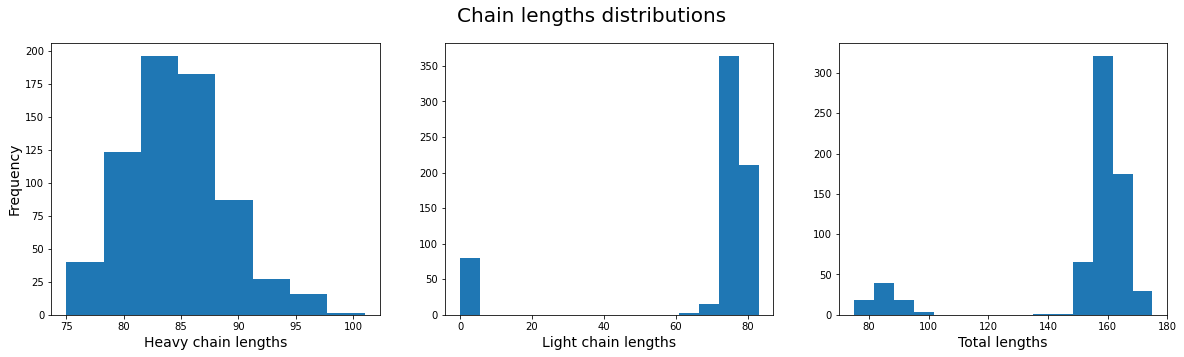

In [3]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Frequency', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

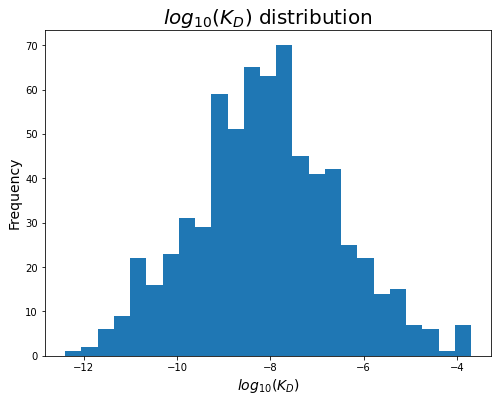

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

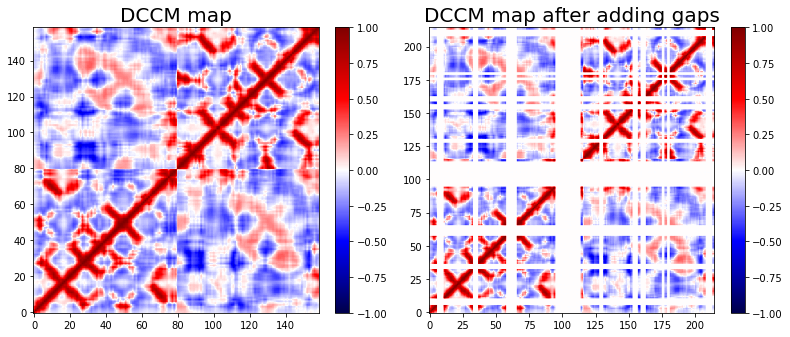

In [5]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[74], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[74].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

plt.colorbar(im1, ax=ax1, fraction=0.045)
plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [6]:
# The test set is generated
train_x, test_x, train_y, test_y = create_testn_set(preprocessed_data.train_x, preprocessed_data.train_y)

In [7]:
# Hyperparameters
n_filters = 2
filter_size = 5
pooling_size = 1
learning_rate = 6e-4

# Defining the model, optimiser and loss function
model = NormalModeAnalysisCNN(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape)
criterion = MSELoss()
optimiser = AdaBelief(model.parameters(), lr=learning_rate, eps=1e-8, print_change_log=False) 

print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
NormalModeAnalysisCNN(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=89042, out_features=1, bias=False)
)


# Training

In [8]:
train_losses = []
test_losses = []

In [36]:
n_max_epochs = 40
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor([[-9.9425]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.4418]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-8.5008]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9350]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.6060]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.9450]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.2715]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.1404]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.6845]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.9192]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8766]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.1554]], grad_fn=<MmBack

tensor([[-9.9580]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5121]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-8.5009]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9897]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.5067]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.9662]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.4120]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3549]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.8561]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.9528]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1241]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.3509]], grad_fn=<MmBack

tensor([[-10.0022]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.4515]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-8.4796]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9110]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.1156]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.8753]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.2562]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3315]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.8129]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.9307]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.0537]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.2881]], grad_fn=<MmBac

tensor([[-9.7537]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.3842]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-8.3630]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.6528]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.1508]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.6424]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.3213]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5024]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.6133]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.8103]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.7811]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.0523]], grad_fn=<MmBack

tensor([[-10.1578]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6726]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-8.7577]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.1064]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.2677]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.1014]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.1384]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4459]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0351]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2924]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.3290]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.4697]], grad_fn=<MmBac

tensor([[-10.0012]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5981]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-8.5920]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.8054]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-5.9571]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.0020]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.0891]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4391]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7765]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.0735]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1540]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.4654]], grad_fn=<MmBac

tensor([[-10.2204]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.7062]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-8.7681]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9294]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-6.4120]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.1956]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.1233]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5719]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.9721]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2541]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.2848]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-6.6860]], grad_fn=<MmBac

In [45]:
#optimiser = AdaBelief(model.parameters(), lr=4e-4, eps=1e-8)#, weight_decouple=False) # th 4e-4 and 8e-4
# 150 (scheduler from 3e-3 to 1.5e-3 in 120 ep), 150, ..., and finally 150 (lr=8e-4)

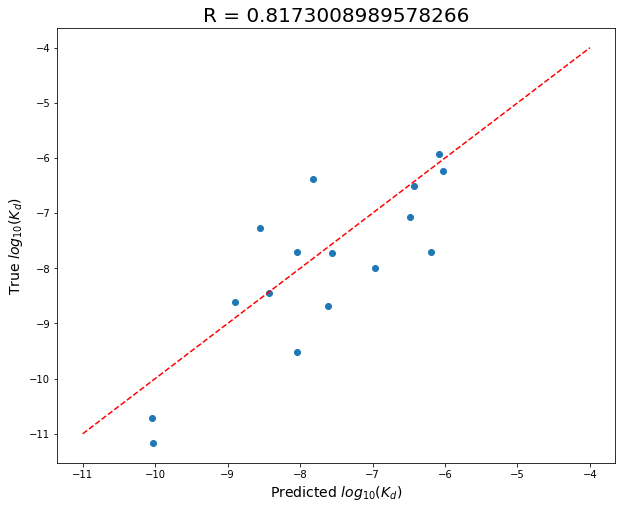

In [61]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(output_test.detach().numpy(), y_test[:,0].detach().numpy())
corr = np.corrcoef(output_test.detach().numpy().T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

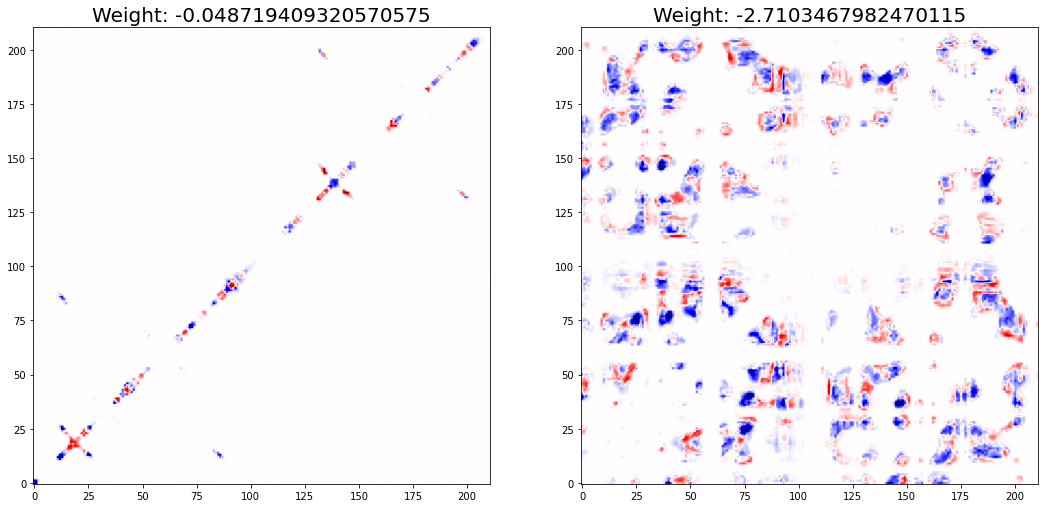

In [56]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
img = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = img
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        img += im_
    im = axs[j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[j].set_title('Weight: '+str(im_.sum()), size=title_size)

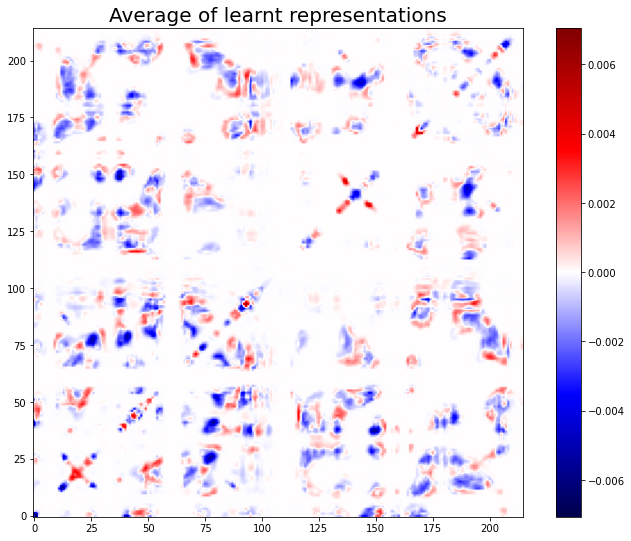

In [62]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(cv2.resize(img, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Average of learnt representations', size=title_size)
plt.colorbar()
plt.show()

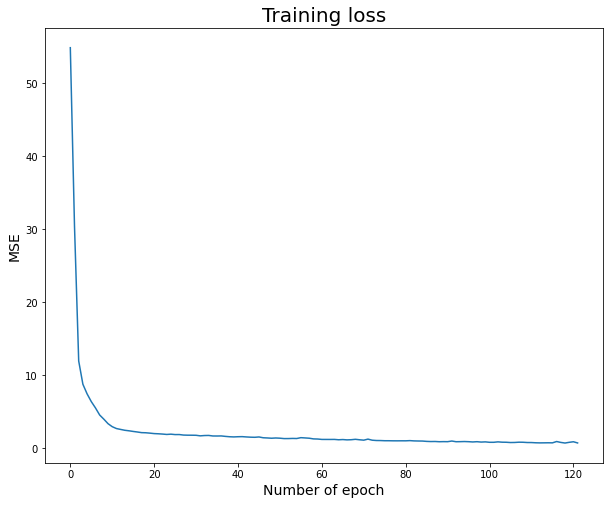

In [63]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

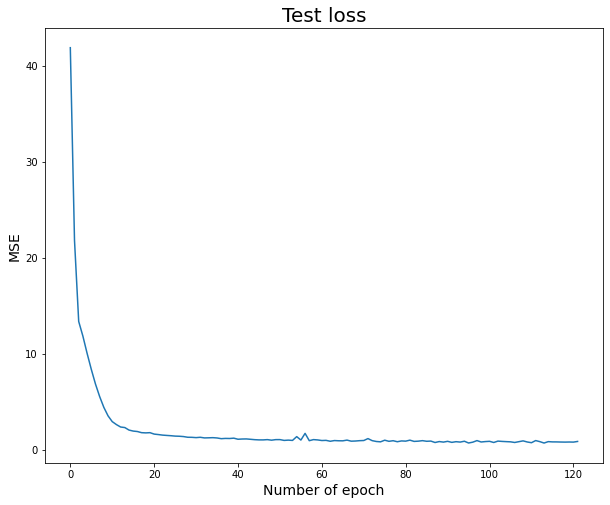

In [75]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i].detach().numpy() for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

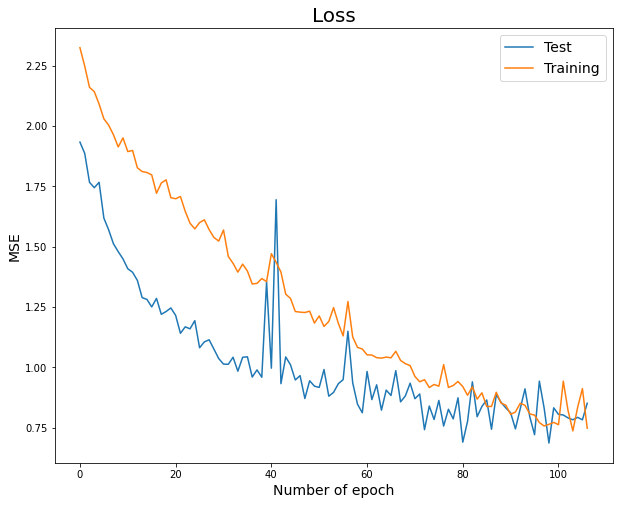

In [76]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[15:][i].detach().numpy() for i in range(len(test_losses[15:]))])
plt.plot([train_losses[15:][i] for i in range(len(train_losses[15:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

In [67]:
model(train_x[40:80])[0]

tensor([[ -8.0577],
        [ -7.8179],
        [ -8.0080],
        [ -6.4184],
        [ -7.1734],
        [ -6.8402],
        [ -7.5330],
        [ -8.1631],
        [-10.6023],
        [ -7.3466],
        [ -7.8821],
        [ -8.5272],
        [ -9.4320],
        [ -8.4729],
        [ -8.4160],
        [ -8.0949],
        [ -7.2604],
        [ -7.1484],
        [ -7.2501],
        [ -8.4152],
        [ -7.1379],
        [ -9.9324],
        [ -7.6490],
        [ -8.5845],
        [ -7.7696],
        [ -8.2606],
        [ -6.2668],
        [ -7.7013],
        [ -7.3893],
        [ -9.3164],
        [ -6.1418],
        [ -5.9598],
        [ -8.6950],
        [-10.1590],
        [ -5.5141],
        [ -6.4445],
        [ -8.0051],
        [ -5.1630],
        [ -7.8254],
        [ -6.2704]], grad_fn=<MmBackward0>)

In [68]:
train_y[40:80]

tensor([[ -9.0269],
        [ -6.7905],
        [ -9.1759],
        [ -5.3098],
        [ -7.0269],
        [ -6.8539],
        [ -5.7959],
        [ -8.4815],
        [-10.7447],
        [ -8.7645],
        [ -8.5935],
        [ -9.5686],
        [-11.6021],
        [ -8.3010],
        [ -8.2218],
        [ -7.0605],
        [ -6.7799],
        [ -7.7212],
        [ -8.2218],
        [ -8.1871],
        [ -8.1141],
        [-11.2441],
        [ -7.6576],
        [ -9.5376],
        [ -7.3279],
        [ -6.6198],
        [ -6.5391],
        [ -7.8539],
        [ -7.7696],
        [ -8.2518],
        [ -7.0000],
        [ -5.3279],
        [ -6.3872],
        [-10.2676],
        [ -5.0555],
        [ -5.7959],
        [ -8.2147],
        [ -4.6198],
        [ -7.5528],
        [ -6.2218]])

In [93]:
# Uncomment the following lines to save a checkpoint

#EPOCH = len(test_losses)
#PATH = '../checkpoints/model_' + str(n_max_epochs) + '_epochs_' + str(pooling_size) + '_pool_' + str(n_filters) + '_filters.pt'
#TR_LOSS = train_losses
#TEST_LOSS = test_losses
#
#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': model.state_dict(),
#            'optimiser_state_dict': optimiser.state_dict(),
#            'tr_loss': TR_LOSS,
#            'test_loss': TEST_LOSS,            
#            }, PATH)